In [1]:
# Create GAN for independent and identically distributed data

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import secrets


class GAN:
    def __init__(self, P1 = 0.7, P2 = 0.4, seq_len=100, latent_dim = 50):
        
        self.P1 = P1
        self.P2 = P2
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        seed = secrets.randbits(128)
        self.rng = np.random.default_rng(seed)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        print(self.P1, self.P2)
    
    def generate_real_samples(self, n_samples):
        X1 = self.rng.binomial(1, self.P1, (n_samples, self.seq_len, 1))
        X2 = self.rng.binomial(1, self.P2, (n_samples, self.seq_len, 1))
        X3 = (X1 + X2) % 2
        X = np.concatenate((X1, X2, X3), axis=2)
        y = np.ones((n_samples, 1)) * 0.9
        return X, y
    
    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, self.latent_dim)))
        y = np.zeros((n_samples, 1))
        return X, y
    
    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        return np.mean(X, axis=(0,1) )
    
    def build_generator(self):
        self.generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(self.seq_len * 200, input_shape=(self.latent_dim,)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Reshape((self.seq_len, 200)),
            tf.keras.layers.LSTM(100, return_sequences=True),
            # tf.keras.layers.LSTM(100, return_sequences=True),
            # tf.keras.layers.LSTM(100, return_sequences=True),
            # tf.keras.layers.Dense(10, activation='relu'),
            
            tf.keras.layers.Dense(3, activation='sigmoid'),
        ])
    def summarize_generator(self):
        self.generator.summary()

    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, input_shape=(self.seq_len, 3), return_sequences=True)),
            # tf.keras.layers.Dropout(0.5),
            # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])
        self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    def summarize_discriminator(self):
        self.discriminator.summary()
    
    def build_gan(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([
            self.generator,
            self.discriminator,
        ])
        self.gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
        
    def train(self, epochs = 10, batch_size = 128, data_size = 200):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        # total = data_size//batch_size
        total = 100000//batch_size
        train_data_x, train_data_y = self.generate_real_samples(data_size)
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
            
            for k in range(total):
                print(k,"/",total,end="\r")
                idx = np.random.randint(0, data_size, batch_size//2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                X_fake, y_fake = self.generate_fake_samples(batch_size//2)
                

                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)
                
                X_fake = np.random.normal(0, 1, (batch_size, self.latent_dim))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)
                
                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)
                
            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(100000)
            print(calc_p)
            pred = gan.generator.predict(np.random.normal(0, 1, (1, 50)))
            print(pred)
            print(gan.discriminator.predict(pred))
            # print("Loss:",np.mean(np.abs(calc_p - self.P)))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

2024-02-16 19:52:37.502891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 19:52:39.442158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-02-16 19:52:39.442290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
gan = GAN()
gan.summarize_generator()
gan.summarize_discriminator()

# print(.shape)

2024-02-16 19:52:43.380892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 19:52:44.030358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:83:00.0, compute capability: 7.5


0.7 0.4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20000)             1020000   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20000)             0         
                                                                 
 reshape (Reshape)           (None, 100, 200)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 100)          120400    
                                                                 
 dense_1 (Dense)             (None, 100, 3)            303       
                                                                 
Total params: 1,140,703
Trainable params: 1,140,703
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
________________

Iteration: 0


2024-02-16 19:52:47.776530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2024-02-16 19:52:52.215092: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1469e0143bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-16 19:52:52.215159: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-02-16 19:52:52.221419: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-16 19:52:52.392224: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[0.8094038  0.3741865  0.59877765]
[[[0.60688776 0.4520985  0.529952  ]
  [0.57040715 0.463784   0.56039894]
  [0.5830584  0.44533396 0.5890673 ]
  [0.5601455  0.42104736 0.6156128 ]
  [0.5415504  0.3830952  0.63219225]
  [0.49522766 0.36085418 0.64633083]
  [0.45750508 0.34229156 0.64104587]
  [0.42594442 0.34178537 0.6294103 ]
  [0.36133564 0.36195368 0.6136568 ]
  [0.28270274 0.39872405 0.58396643]
  [0.23512645 0.44651502 0.52461535]
  [0.21518297 0.49481222 0.45138586]
  [0.23747852 0.539492   0.37691528]
  [0.30963925 0.575446   0.3236455 ]
  [0.44108316 0.6005279  0.3087176 ]
  [0.6087342  0.59232473 0.33873138]
  [0.71386915 0.5430852  0.41448456]
  [0.78693175 0.4650583  0.51513803]
  [0.83707416 0.3650739  0.6252656 ]
  [0.8332707  0.30060816 0.7130359 ]
  [0.80406487 0.26156166 0.7403236 ]
  [0.7901834  0.26241076 0.6637166 ]
  [0.7997455  0.2901603  0.4891191 ]
  [0.8363726  0.39979908 0.40040115]
  [0.8919048  0.45025843 0.39426085]
  [0.91342235 0.45796365 0.4488727 ]
  [

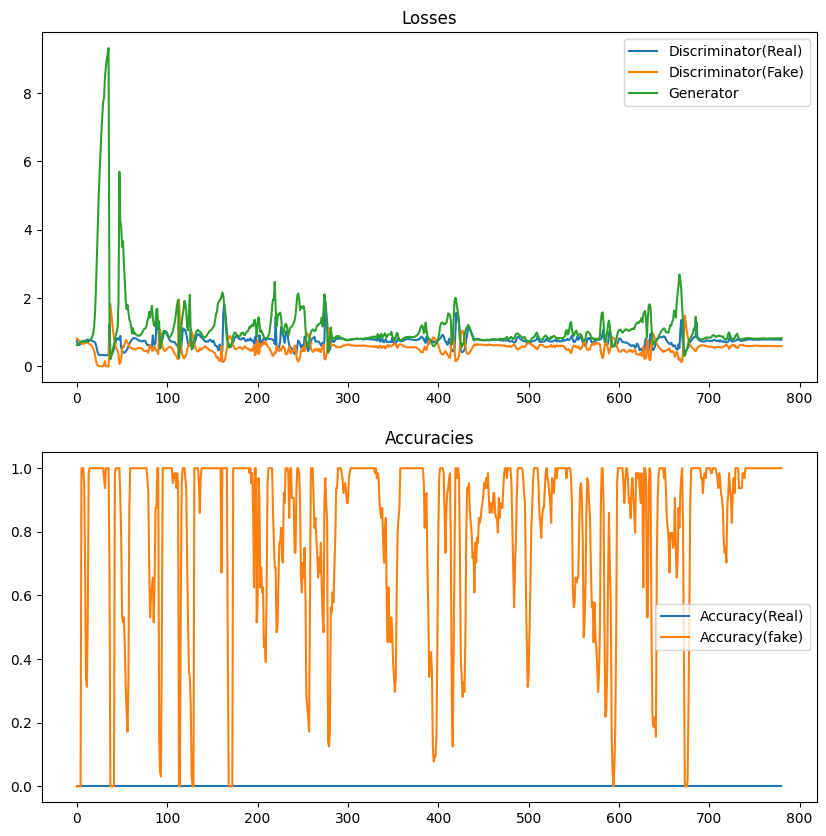

Iteration: 1
[0.5559723  0.45642415 0.63446826]
[[[0.9490227  0.01463393 0.97548974]
  [0.9643935  0.02542121 0.9719524 ]
  [0.9367719  0.11464539 0.9157587 ]
  [0.82824665 0.53560454 0.695758  ]
  [0.62697    0.7864385  0.4459911 ]
  [0.36214682 0.8156621  0.35212496]
  [0.14592049 0.83773965 0.3284503 ]
  [0.06714684 0.86868906 0.32519796]
  [0.07574829 0.786705   0.4828237 ]
  [0.37689325 0.16558369 0.90577114]
  [0.81971145 0.01909567 0.9780878 ]
  [0.92436767 0.02143661 0.9813203 ]
  [0.85136056 0.17176653 0.90997213]
  [0.7443642  0.5630063  0.6665242 ]
  [0.5842579  0.7604397  0.37189835]
  [0.3767631  0.78320867 0.25817212]
  [0.18182255 0.7444193  0.2751757 ]
  [0.09341938 0.694726   0.37157214]
  [0.07248227 0.66139215 0.48851627]
  [0.09121305 0.6311137  0.59664303]
  [0.14243932 0.625562   0.6720269 ]
  [0.19185409 0.71777207 0.6965355 ]
  [0.24671337 0.8197138  0.662189  ]
  [0.2945616  0.8564129  0.625901  ]
  [0.35079026 0.8688836  0.5773033 ]
  [0.45996127 0.85741687 0.

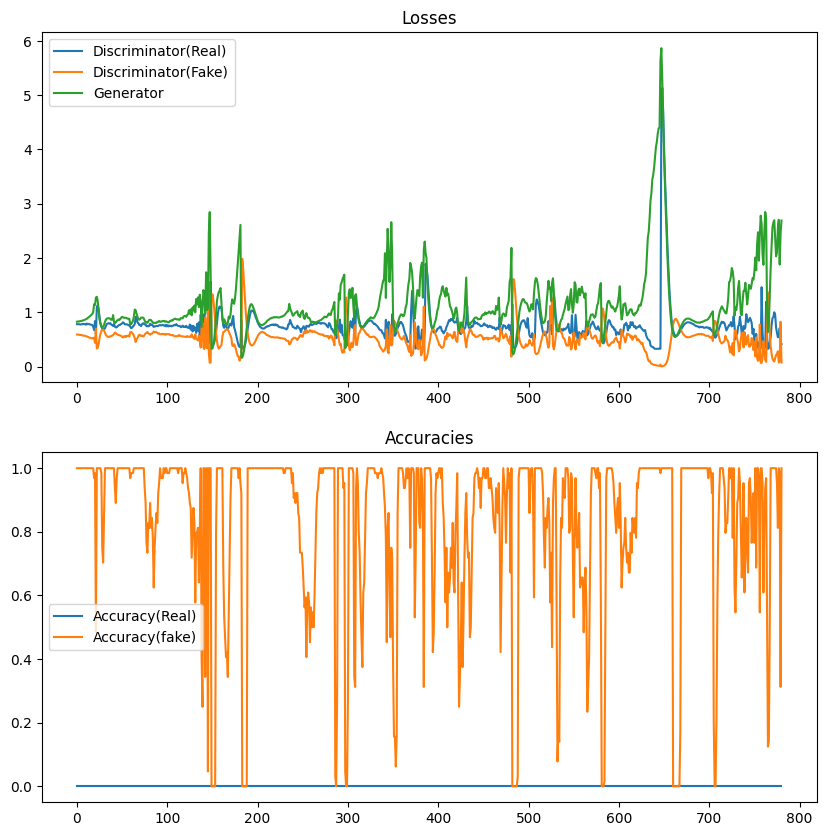

Iteration: 2
[0.6836912 0.4076427 0.5796183]
[[[2.50191684e-03 9.99854207e-01 7.86457583e-03]
  [9.93282557e-01 7.65577715e-05 9.99505162e-01]
  [1.63099602e-01 9.98628020e-01 2.75867302e-02]
  [9.98763680e-01 1.08014647e-04 9.97140288e-01]
  [9.98157203e-01 6.24609692e-03 6.57847047e-01]
  [9.79806125e-01 9.99305129e-01 4.79686918e-04]
  [9.99620199e-01 6.47689812e-05 9.95415807e-01]
  [9.64382648e-01 9.97919619e-01 1.48563110e-03]
  [8.96308124e-01 9.93589878e-01 1.02181570e-03]
  [9.99658942e-01 1.01464349e-04 9.95112240e-01]
  [9.92237508e-01 9.91870999e-01 2.52331002e-03]
  [8.28196526e-01 9.99730527e-01 5.41097717e-04]
  [9.99685526e-01 8.31587240e-05 9.96636510e-01]
  [9.94791508e-01 9.97695625e-01 1.86578557e-03]
  [8.45420361e-01 9.99690890e-01 8.87159724e-04]
  [9.74171817e-01 1.62863324e-03 9.88696456e-01]
  [5.30377150e-01 7.41567671e-01 4.60351497e-01]
  [3.16124707e-01 3.79696041e-02 8.38351488e-01]
  [9.62696254e-01 2.14995540e-04 9.97751415e-01]
  [1.24812350e-01 9.9787

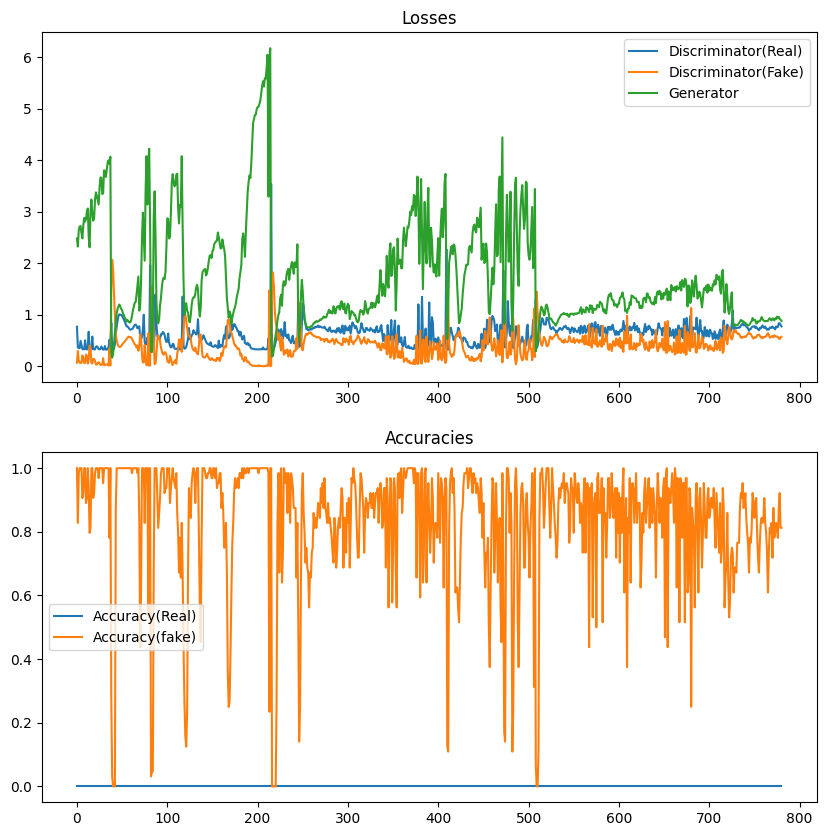

Iteration: 3
[0.6635928 0.3772812 0.5144073]
[[[9.33773458e-01 5.61146080e-05 9.68756735e-01]
  [7.92937726e-03 9.97097731e-01 1.48195450e-05]
  [9.99421835e-01 2.35197484e-04 9.98708487e-01]
  [1.42417684e-01 7.57610440e-01 1.43860206e-02]
  [2.51839925e-02 2.20331014e-03 3.95861119e-01]
  [3.41054797e-03 2.01348145e-03 2.25534607e-02]
  [9.08341765e-01 1.16537616e-01 2.37423196e-01]
  [9.99828935e-01 2.39219749e-04 9.99378443e-01]
  [5.55002034e-01 1.69506238e-04 7.90433347e-01]
  [9.92515266e-01 4.70762170e-05 9.93790567e-01]
  [3.10014755e-01 2.25279760e-03 1.62362382e-01]
  [2.17819020e-01 2.44403818e-05 9.84789252e-01]
  [6.11033430e-03 9.74829435e-01 5.81238768e-04]
  [9.93431985e-01 9.99808133e-01 6.76474115e-03]
  [9.99363840e-01 9.99735653e-01 1.07202075e-01]
  [9.71440375e-01 9.26623907e-05 9.98295248e-01]
  [3.82798084e-04 5.62690804e-03 7.34483649e-04]
  [5.92377484e-01 5.11748658e-04 1.98358390e-02]
  [1.32780732e-03 4.52021463e-03 8.12282524e-05]
  [9.99866486e-01 2.6805

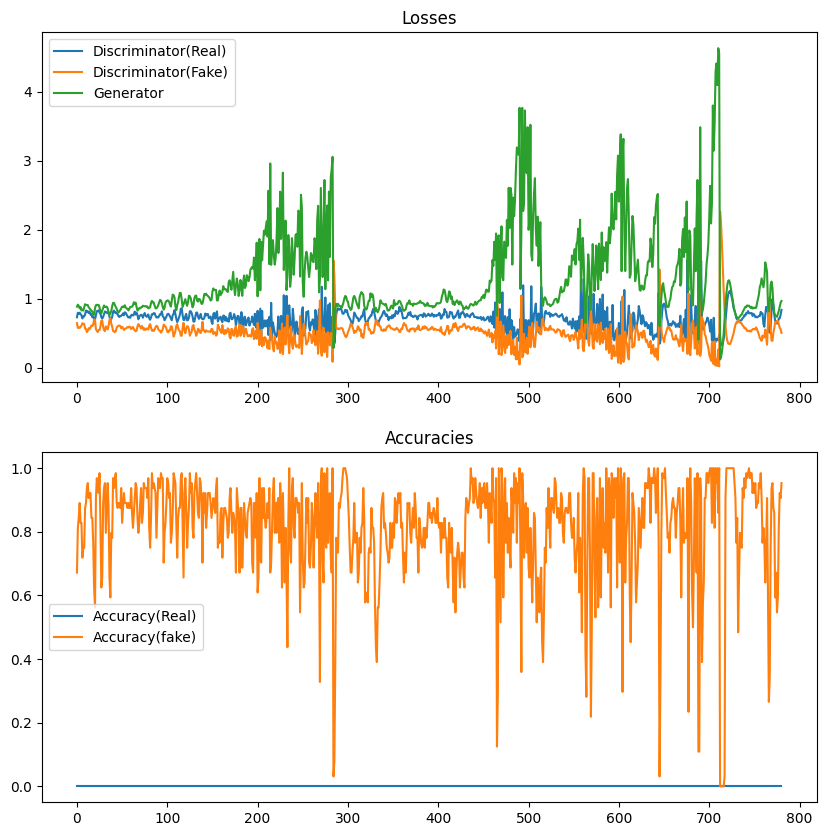

Iteration: 4
[0.6995125  0.38817093 0.53279024]
[[[9.90009606e-01 8.80761887e-04 6.74330295e-05]
  [9.99997973e-01 1.48736901e-04 9.99838233e-01]
  [5.16822599e-02 9.99676943e-01 9.99758303e-01]
  [9.99997616e-01 2.90019852e-05 9.99977112e-01]
  [4.98121046e-03 9.99940157e-01 9.62877154e-01]
  [9.99893904e-01 9.99951601e-01 5.26435397e-05]
  [9.99896765e-01 9.99951839e-01 8.27138647e-05]
  [9.99965191e-01 9.99937534e-01 2.40537353e-04]
  [9.99503255e-01 9.99822795e-01 6.72855531e-05]
  [9.97578204e-01 1.48206473e-05 9.99940395e-01]
  [9.99983072e-01 3.64203152e-05 9.99992251e-01]
  [9.99996305e-01 1.05606368e-05 9.99983907e-01]
  [4.87940526e-03 9.94799972e-01 1.92038751e-05]
  [9.99997497e-01 7.31322143e-05 9.99961257e-01]
  [9.99976993e-01 9.99959946e-01 4.78724614e-05]
  [9.99849081e-01 9.99948740e-01 4.52361528e-05]
  [1.82277098e-01 9.98717785e-01 9.99986172e-01]
  [9.99990702e-01 2.00376162e-04 9.99955058e-01]
  [9.99792278e-01 4.26011284e-05 9.99579132e-01]
  [9.99879837e-01 1.2

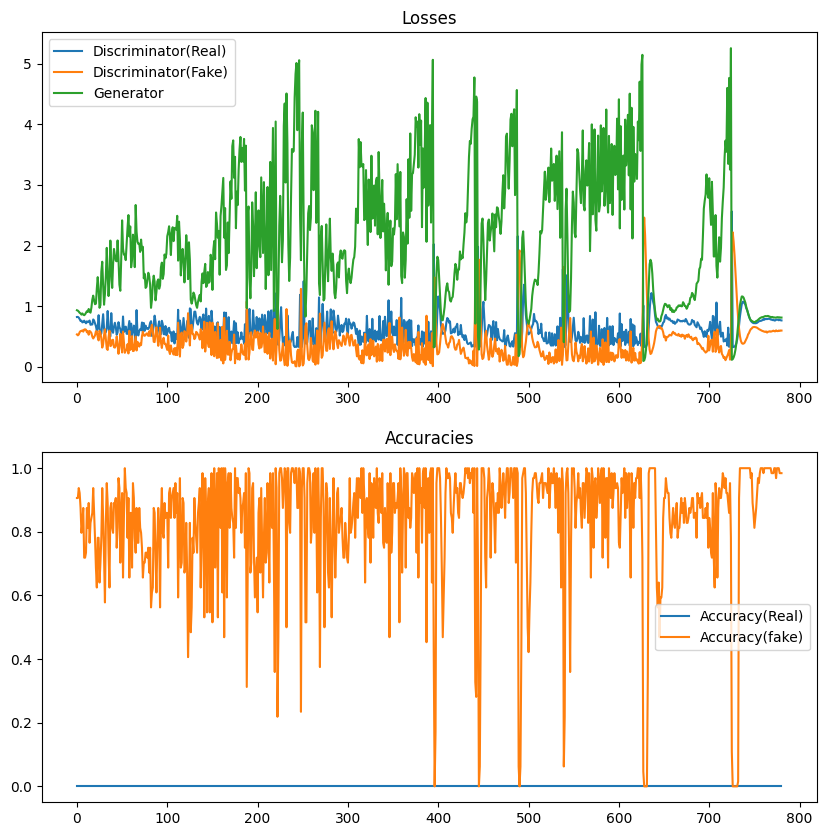

Iteration: 5
[0.70783573 0.39396256 0.5360609 ]
[[[9.47274983e-01 2.53025428e-05 3.97391953e-02]
  [9.99993801e-01 1.95837874e-05 9.99972105e-01]
  [9.99993324e-01 3.07759510e-05 9.99990225e-01]
  [9.99962807e-01 9.99954939e-01 2.58562850e-05]
  [9.99692440e-01 9.99979019e-01 1.22608582e-03]
  [5.51897699e-07 4.17725416e-03 9.99913931e-01]
  [9.99618053e-01 9.99982953e-01 2.17394845e-05]
  [9.99987721e-01 2.09904494e-04 8.10333312e-01]
  [9.95327830e-01 1.91766338e-03 5.49478364e-06]
  [9.99996781e-01 2.72103571e-05 9.99982595e-01]
  [9.99992728e-01 1.93303076e-05 9.99945760e-01]
  [9.99996305e-01 2.17681136e-05 9.99987006e-01]
  [1.59817643e-03 9.99961734e-01 9.99632001e-01]
  [9.99987245e-01 1.89480998e-05 9.99998450e-01]
  [9.99841928e-01 9.99997377e-01 1.09920325e-03]
  [9.97538328e-01 1.04163548e-04 9.99988675e-01]
  [3.59926868e-04 9.99984503e-01 9.99998808e-01]
  [1.94220722e-01 9.99891877e-01 9.16738659e-02]
  [3.02592933e-04 1.02207214e-05 7.16609284e-05]
  [9.99996543e-01 3.7

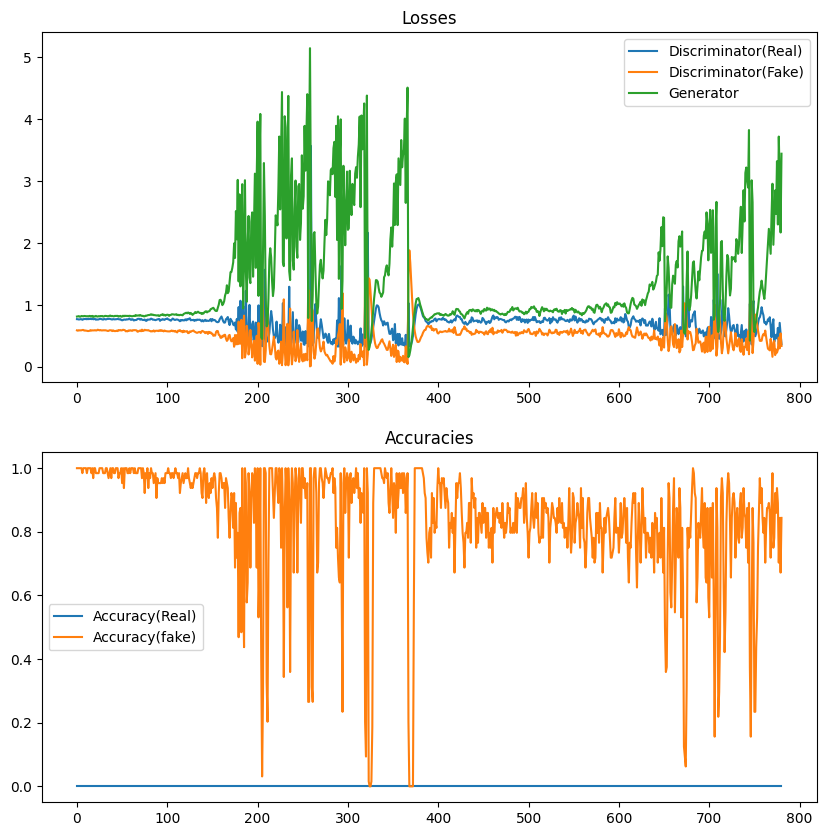

Iteration: 6
[0.673929   0.39376336 0.55392504]
[[[7.6086986e-01 2.8852028e-05 4.7855982e-01]
  [9.9996376e-01 9.9995732e-01 2.0826858e-05]
  [9.9392748e-01 9.9999750e-01 9.9628323e-01]
  [6.3319771e-05 9.9992621e-01 9.9998677e-01]
  [9.9952054e-01 9.9999833e-01 8.4715075e-04]
  [9.9995947e-01 2.4739438e-05 9.9999571e-01]
  [9.9996698e-01 9.9995685e-01 2.2101671e-05]
  [9.9999535e-01 1.7977158e-05 9.9999189e-01]
  [9.9990439e-01 9.9998808e-01 4.3770378e-05]
  [9.9998963e-01 3.3997025e-05 9.9999022e-01]
  [7.4835136e-03 9.9973565e-01 9.9987781e-01]
  [9.9996400e-01 9.9998939e-01 3.4689652e-05]
  [8.8522960e-05 1.0604831e-05 1.7620529e-05]
  [9.9836737e-01 9.9999201e-01 7.4297324e-02]
  [9.9998283e-01 9.9998629e-01 1.9407666e-05]
  [1.6988437e-03 1.0331243e-05 9.9070221e-06]
  [9.9999237e-01 2.9941790e-05 9.9999738e-01]
  [4.1316228e-04 1.9179381e-06 1.3891595e-05]
  [6.5310620e-04 9.9995363e-01 9.9987602e-01]
  [1.2749157e-04 9.9996376e-01 9.9992049e-01]
  [9.9999762e-01 4.6984231e-05 9

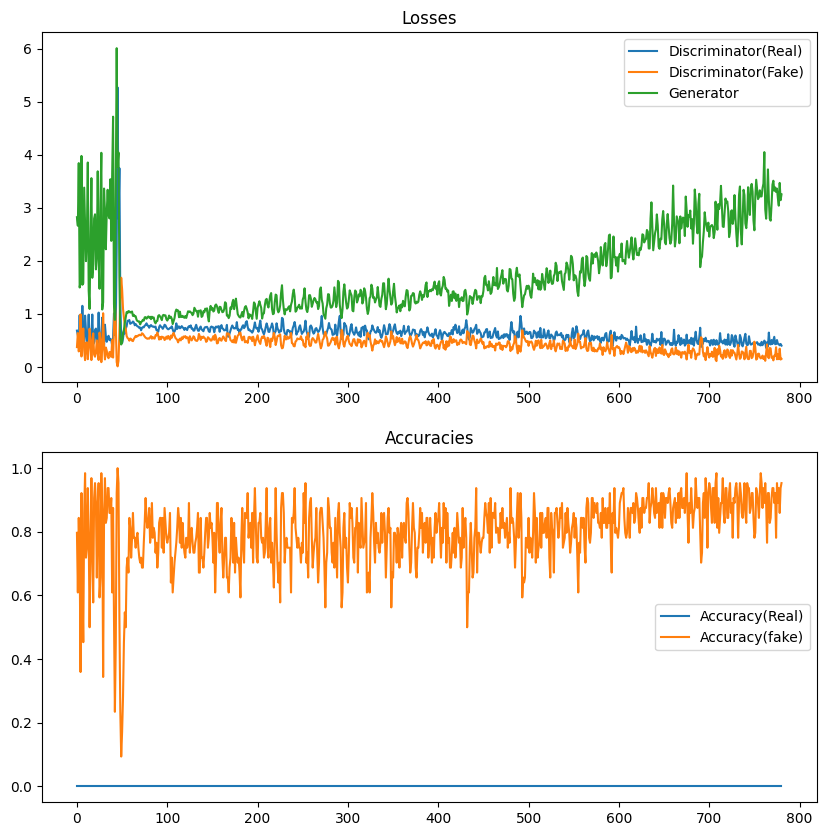

Iteration: 7
[0.6964047  0.40990636 0.54420626]
[[[9.99977231e-01 9.99999285e-01 7.79791590e-05]
  [9.99997139e-01 9.40669452e-06 9.99995708e-01]
  [9.99997616e-01 6.20551930e-07 9.94339287e-01]
  [9.99999285e-01 1.28377787e-05 9.99998569e-01]
  [9.99926925e-01 9.99999881e-01 2.30672467e-03]
  [9.99987364e-01 8.69815085e-06 9.99997854e-01]
  [1.91256695e-05 2.60064166e-06 1.04464461e-05]
  [1.20200649e-01 1.17194613e-05 7.50991981e-03]
  [5.31957085e-06 1.27330677e-05 4.78554193e-06]
  [9.30375516e-01 8.60553049e-03 2.80207729e-07]
  [3.63213949e-05 4.46689182e-06 5.69173535e-05]
  [9.99985099e-01 3.60127530e-07 9.97906089e-01]
  [4.20150161e-01 9.99908686e-01 9.99999881e-01]
  [9.99987125e-01 9.99999404e-01 4.28363157e-04]
  [9.99994636e-01 9.99999404e-01 6.16921825e-05]
  [5.06163985e-07 9.99564230e-01 9.99909401e-01]
  [8.36171785e-06 9.99999166e-01 9.99999642e-01]
  [9.99998569e-01 1.33905205e-05 9.99994159e-01]
  [3.39365797e-05 5.30131558e-07 3.28414512e-06]
  [9.99999404e-01 8.9

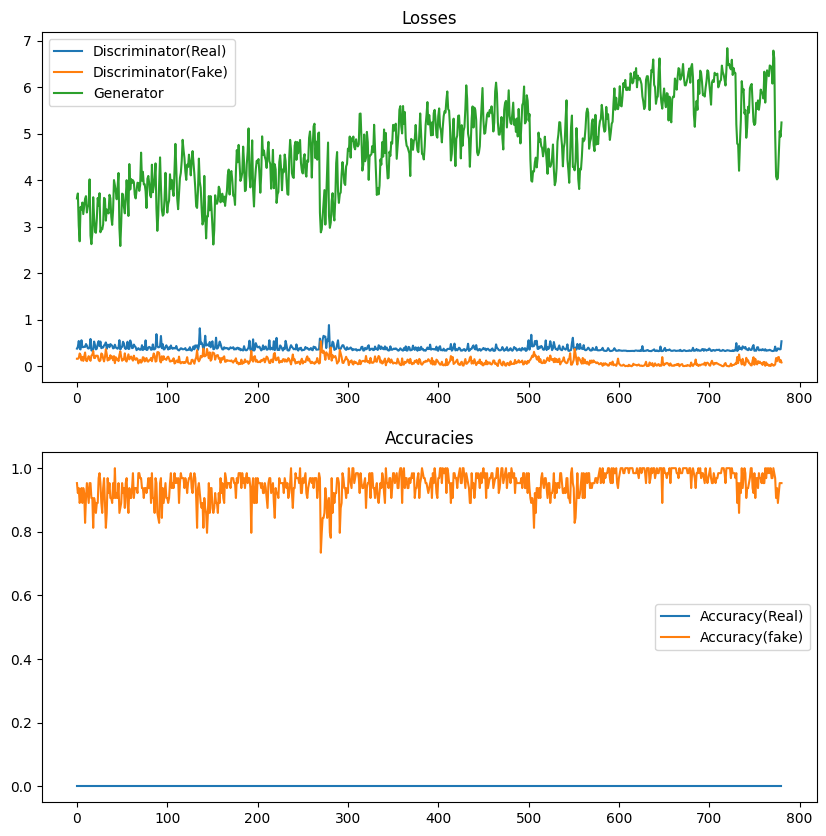

Iteration: 8
[0.6676554  0.39842355 0.5721406 ]
[[[1.10838828e-05 3.82210419e-06 1.76131050e-06]
  [9.99988914e-01 9.99996901e-01 3.26448098e-05]
  [9.99999642e-01 8.64237154e-06 9.99995589e-01]
  [9.99895811e-01 9.99996305e-01 6.23798405e-04]
  [9.99999046e-01 4.25136977e-06 9.99997973e-01]
  [9.99876261e-01 9.99999881e-01 3.70914349e-04]
  [9.99999762e-01 4.12882173e-06 9.99998331e-01]
  [9.99824464e-01 9.99999881e-01 1.58956402e-03]
  [3.26329056e-04 2.62346130e-05 7.23545730e-01]
  [9.99989629e-01 9.99998212e-01 2.38056200e-05]
  [9.99998331e-01 9.99999762e-01 1.50621636e-05]
  [9.99999881e-01 1.38564108e-04 9.99498367e-01]
  [9.99999285e-01 4.56131329e-06 9.99998808e-01]
  [9.99996185e-01 9.99999762e-01 1.22252422e-05]
  [9.99999762e-01 9.99999285e-01 6.10406161e-04]
  [9.99999642e-01 7.16921704e-06 9.99999881e-01]
  [9.99999523e-01 2.37979020e-06 9.99994993e-01]
  [9.99951959e-01 3.68897395e-06 9.99993324e-01]
  [9.99996424e-01 9.99999642e-01 5.76201302e-04]
  [9.99995828e-01 9.9

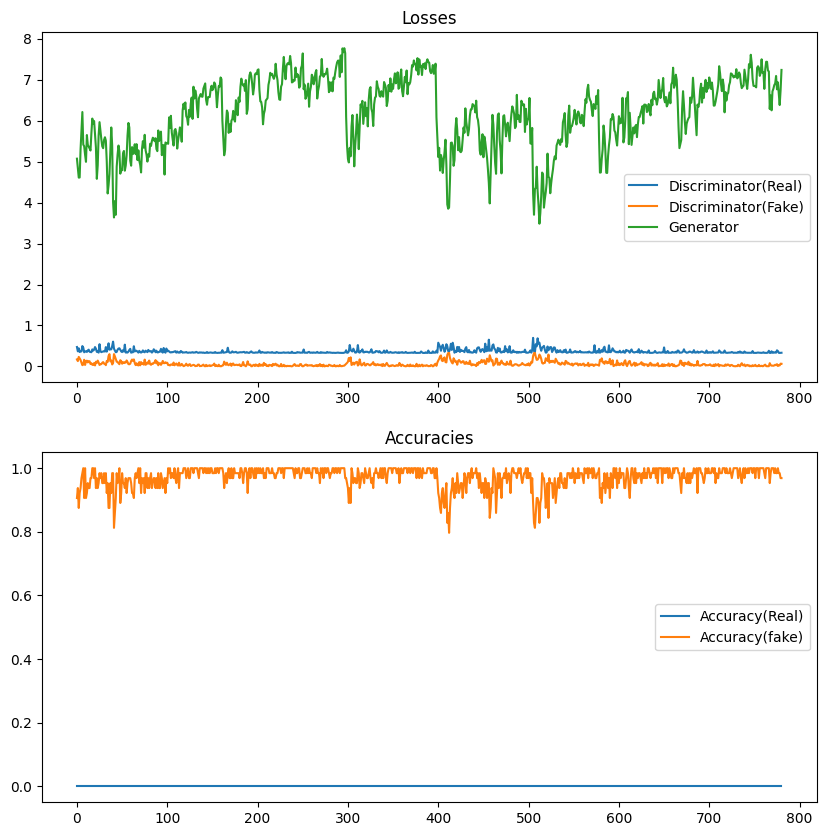

Iteration: 9
[0.68012434 0.3878345  0.5525124 ]
[[[5.65328123e-03 9.99032617e-01 1.00000000e+00]
  [1.34276931e-07 9.99994159e-01 1.00000000e+00]
  [3.51517633e-06 1.12812750e-05 3.17185732e-06]
  [3.70699831e-06 5.82599398e-07 3.46979641e-06]
  [9.99992728e-01 9.99997139e-01 7.49177207e-06]
  [9.99918818e-01 9.75627700e-06 9.99994874e-01]
  [9.98431385e-01 9.99999404e-01 2.99009718e-02]
  [1.75938458e-05 2.07251378e-06 1.05339837e-04]
  [9.99997377e-01 9.99997139e-01 2.88647407e-05]
  [9.99962449e-01 9.99999881e-01 2.51706014e-03]
  [9.78016376e-01 3.84485065e-06 9.99992847e-01]
  [9.99999642e-01 1.52186760e-06 9.99998450e-01]
  [5.71269993e-06 9.99887466e-01 9.99919891e-01]
  [9.41822873e-06 2.56885573e-06 1.69850910e-06]
  [4.61525467e-08 9.99999046e-01 9.99958992e-01]
  [1.84749126e-07 9.99995947e-01 9.99999285e-01]
  [9.99994636e-01 9.99999762e-01 6.41906227e-05]
  [9.99996305e-01 1.00000000e+00 6.82477694e-05]
  [9.99996662e-01 1.80884908e-05 9.99999404e-01]
  [9.99954581e-01 9.9

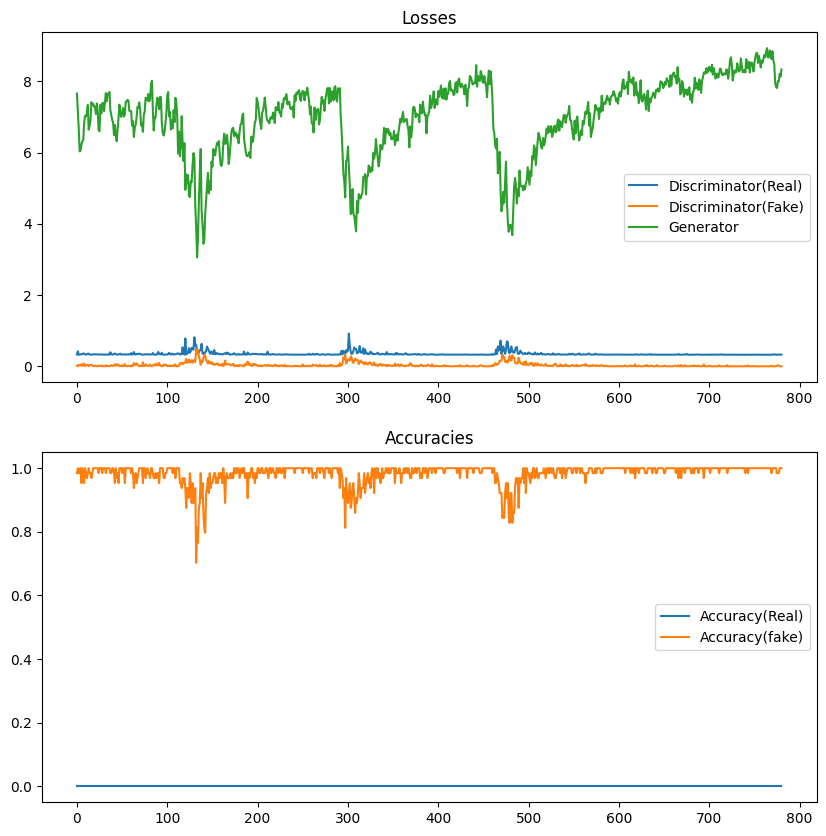

In [3]:
tf.keras.utils.disable_interactive_logging()
gan.train(epochs=10)

In [7]:
print((gan.generator.predict(np.random.normal(0, 1, (1, 50)))))
print((gan.generate_real_samples(1)[0]))

[[[1.26337898e-06 1.67852568e-06 5.58531667e-07]
  [3.63329559e-06 8.48420996e-07 5.70349494e-06]
  [9.99999046e-01 9.99945402e-01 2.30661590e-06]
  [1.00000000e+00 1.63112109e-05 9.99995947e-01]
  [9.99921799e-01 4.59006660e-05 1.00000000e+00]
  [9.99997139e-01 6.62081391e-07 9.99989152e-01]
  [9.99998093e-01 3.96167877e-07 9.99998689e-01]
  [2.04774710e-06 9.99994278e-01 9.99989152e-01]
  [6.44209649e-06 9.99975562e-01 9.99532700e-01]
  [2.17607496e-08 7.69969774e-05 5.53697646e-01]
  [9.99999642e-01 2.11643192e-06 9.99995828e-01]
  [9.99999642e-01 2.61762864e-07 9.99997377e-01]
  [9.99996901e-01 9.99997377e-01 9.63174989e-06]
  [9.99999285e-01 9.99998093e-01 5.05665457e-06]
  [9.96026993e-01 5.44133084e-03 7.23649620e-08]
  [7.75447234e-07 9.99996662e-01 9.99777257e-01]
  [2.72830621e-05 9.99983788e-01 9.99998808e-01]
  [9.99999285e-01 1.55100781e-06 9.99999046e-01]
  [9.98822629e-01 7.92369903e-08 9.99966860e-01]
  [9.99880552e-01 9.99999404e-01 1.83322001e-04]
  [9.99999046e-01 9.

In [8]:
x = gan.generator.predict(np.random.normal(0, 1, (10000, 50)))
y = np.ones(x.shape)
print(x.min(),x.max(), x.mean())
print(x.shape)
X1, X2, X3 = np.dsplit(x, 3)
# print(X1.shape)
fig = plt.figure(figsize=(100, 100))
ax = fig.subplots()
vals = ax.hist(X1.flatten(), bins=100, alpha=0.5, label="Generated", range=(0,1))
# ax.set_xlim([-0.5,1.5])
ax.set_ylim([0, vals[0].max() + 10000])
# ax.set_xticks(np.arange(-0.5, 1.5, (1.5+0.5)/10))   
fig.show()
fig = plt.figure(figsize=(100, 100))
ax = fig.subplots()
vals = ax.hist(X2.flatten(), bins=100, alpha=0.5, label="Generated", range=(0,1))
# ax.set_xlim([-0.5,1.5])
ax.set_ylim([0, vals[0].max() + 10000])
# ax.set_xticks(np.arange(-0.5, 1.5, (1.5+0.5)/10))   
fig.show()
fig = plt.figure(figsize=(100, 100))
ax = fig.subplots()
vals = ax.hist(X3.flatten(), bins=100, alpha=0.5, label="Generated", range=(0,1))
# ax.set_xlim([-0.5,1.5])
ax.set_ylim([0, vals[0].max() + 10000])
# ax.set_xticks(np.arange(-0.5, 1.5, (1.5+0.5)/10))   
fig.show()

1.7358292e-11 1.0 0.54031116
(10000, 100, 3)


In [9]:
X1, X2, X3 = np.rint(X1), np.rint(X2), np.rint(X3)
print(100*np.count_nonzero((X1 + X2) % 2 - X3)/(10000 * 100), "% wrong")

3.9471 % wrong
